In [ ]:
%load_ext autoreload
%autoreload 2
import os

os.environ["PREFECT__FLOWS__CHECKPOINTING"] = "True"

import fsspec
import pandas as pd
import xarray as xr
import numpy as np
import cmip6_downscaling
import numpy as np
from xarray_schema import DataArraySchema, DatasetSchema

from cmip6_downscaling.data.observations import open_era5
from cmip6_downscaling.data.cmip import get_gcm, load_cmip
from dask.distributed import Client, LocalCluster
import warnings
warnings.filterwarnings("ignore")
import pytest
from cmip6_downscaling.analysis import analysis, metrics
from cmip6_downscaling.analysis.analysis import qaqc_checks, grab_top_city_data, load_top_cities, get_seasonal, change_ds
from cmip6_downscaling.analysis.plot import plot_cdfs, plot_values_and_difference, plot_seasonal
from cmip6_downscaling.analysis.qaqc import make_qaqc_ds
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from carbonplan import styles

styles.mpl.set_theme(style='carbonplan_light')


In [ ]:
# Pass as a parameter to be used by papermill: the runid which will be used to create the template for the raw and summary files
run_id = "MIROC6-ssp370-1990-1990-2090-2090-55-60-80-85-tasmax"
var = "tasmax"
gcm = "MIROC6"
scenario = "ssp370"
train_period_start = "1990"
train_period_end = "1990"
predict_period_start = "1990"
predict_period_end = "1990"

# Load in your data


Load in downscaled run


In [ ]:
ds = xr.open_zarr(
    f"az://flow-outputs/results/postprocess-results-{run_id}.zarr"
).drop("dayofyear")

Load in observational dataset for evaluation below.


In [ ]:
training_period = slice(training_period_start, training_period_end)
future_period = slice(predict_period_start, predict_period_end)

In [ ]:
obs_ds = open_era5(
    start_year=training_period.start,
    end_year=training_period.stop,
    variables=[var],
)
if var == "pr":
    obs_ds *= (
        86400  # can remove this once ERA5 is rescaled in open_era5 function
    )

Load in raw GCM (not downscaled or bias-corrected).


In [ ]:
gcm = get_gcm(gcm, scenario, variables=[var])

Load in observational dataset for evaluation below.


In [ ]:
training_period = slice("1991", "1995")
future_period = slice("2071", "2075")

In [ ]:
obs_ds = open_era5(
    start_year=training_period.start,
    end_year=training_period.stop,
    variables=[var],
)
if var == "pr":
    obs_ds *= (
        86400  # can remove this once ERA5 is rescaled in open_era5 function
    )

Load in raw GCM (not downscaled or bias-corrected).


In [ ]:
gcm = get_gcm(gcm, scenario, variables=[var])

# QAQC Routines

Search for nans and aphysical quantitities


In [ ]:
annual_qaqc_ts, qaqc_maps = qaqc_checks(ds.isel(time=slice(0, 365)))

What years, if any, include QAQC issues?


In [ ]:
if annual_qaqc_ts.sum().values.any():
    print(annual_qaqc_ts)

Where, if anywhere, do those QAQC issues happen?


In [ ]:
for var in qaqc_maps:
    if qaqc_maps[var].sum().values.any():
        qaqc_maps[var].plot(col_wrap=1, col="qaqc_check")

# Evaluation over training period

How well do statistics of downscaled GCM data look like observations? In other
words, did the model perform as expected and are there any other side-effects.


First, let's look at some individual locations around the world (we'll look at a
sampling of the biggest cities). We'll compare the statistics of the historical
downscaled data with the observations dataset and see how they match. Depending
on the metric they should align very well (if that metric was used in training)
but other metrics might differ still.


Load in the training dataset (ERA5)


for var in qaqc_maps:
    if qaqc_maps[var].sum().values.any():
        qaqc_maps[var].plot(col_wrap=1, col="qaqc_check")

# Evaluation over training period

How well do statistics of downscaled GCM data look like observations? In other
words, did the model perform as expected and are there any other side-effects.


First, let's look at some individual locations around the world (we'll look at a
sampling of the biggest cities). We'll compare the statistics of the historical
downscaled data with the observations dataset and see how they match. Depending
on the metric they should align very well (if that metric was used in training)
but other metrics might differ still.


Load in the training dataset (ERA5)


In [ ]:
We'll do our analyses across the 100 biggest cities (all in different countries
so as to provide some geographic diversity). Also added a few in the Western US
to cover that part of the world.


In [ ]:
plot_cdfs(
    obs_cities,
    downscaled_cities.sel(time=training_period),
    downscaled_cities.sel(time=future_period),
    top_cities,
    training_period,
    future_period,
    gcm_cities.sel(time=training_period),
    gcm_cities.sel(time=future_period),
    sharex=True,
)

In [ ]:
[obs_cities, downscaled_cities, gcm_cities] = grab_top_city_data(
    [obs_ds[var], ds[var], gcm[var]], top_cities
)

In [ ]:
plot_cdfs(
    obs_cities,
    downscaled_cities.sel(time=training_period),
    downscaled_cities.sel(time=future_period),
    top_cities,
    training_period,
    future_period,
    gcm_cities.sel(time=training_period),
    gcm_cities.sel(time=future_period),
    sharex=True,
)

In [ ]:
plot_cdfs(
    obs_cities,
    downscaled_cities.sel(time=training_period),
    downscaled_cities.sel(time=future_period),
    top_cities,
    training_period,
    future_period,
    gcm_cities.sel(time=training_period),
    gcm_cities.sel(time=future_period),
    sharex=False,
)

# Performance of standard statistics


In [ ]:
for metric in ["mean", "median", "std"]:  # , 'percentile1',
    # 'percentile5', 'percentile95', 'percentile99']:
    plot_values_and_difference(
        metrics.metric_calc(obs_ds.sel(time=training_period), metric)[var],
        metrics.metric_calc(ds.sel(time=training_period), metric)[var],
        title1="GCM change in {}".format(metric),
        title2="Downscaled change in {}".format(metric),
        title3="Difference downscaled-GCM",
        variable=var,
        metric=metric,
    )

# Hot days

Calculate the average number of hot days (over 30c) within observations and
downscaled model.


In [ ]:
if var == "tasmax":
    days_over_30c_era5 = metrics.days_temperature_threshold(
        obs_ds, "over", 273 + 30
    ).compute()
    days_over_30c_ds = metrics.days_temperature_threshold(
        ds.sel(time=training_period), "over", 273 + 30
    ).compute()
    plot_values_and_difference(
        days_over_30c_era5["tasmax"],
        days_over_30c_ds["tasmax"],
        cbar_kwargs={"label": "Days over 30C"},
        diff_limit=20,
    )

# Very hot days

Performance: the average number of very hot days (over 40c)


In [ ]:
if var == "tasmax":
    days_over_40c_era5 = metrics.days_temperature_threshold(
        obs_ds, "over", 273 + 40
    ).compute()
    days_over_40c_ds = metrics.days_temperature_threshold(
        ds.sel(time=training_period), "over", 273 + 40
    ).compute()
    plot_values_and_difference(
        days_over_40c_era5["tasmax"],
        days_over_40c_ds["tasmax"],
        cbar_kwargs={"label": "Days over 40C"},
    )

# Is the change seen in the downscaled dataset the same as the change projected by the raw GCM?


In [ ]:
downscaled_change_cities = change_ds(
    downscaled_cities.sel(time=training_period),
    downscaled_cities.sel(time=future_period),
)
gcm_change_cities = change_ds(
    gcm_cities.sel(time=training_period), gcm_cities.sel(time=future_period)
)

In [ ]:
for metric in gcm_change_cities:
    plot_values_and_difference(
        gcm_change_cities[metric],
        downscaled_change_cities[metric],
        gcm_change_cities,
        city_coords=obs_cities,
        title1="GCM change in {}".format(metric),
        title2="Downscaled change in {}".format(metric),
        title3="Difference downscaled-GCM",
        variable=var,
        metric=metric,
    )

# Seasonal statistics


### Assess the mean value over the season


In [ ]:
aggregator = "mean"
obs_seasonal = get_seasonal(obs_ds, aggregator=aggregator)
downscaled_seasonal = get_seasonal(
    ds.sel(time=training_period), aggregator=aggregator
)

In [ ]:
plot_seasonal(obs_seasonal["tasmax"], downscaled_seasonal["tasmax"])

In [ ]:
aggregator = "max"
obs_seasonal = get_seasonal(obs_ds, aggregator=aggregator)
downscaled_seasonal = get_seasonal(
    ds.sel(time=training_period), aggregator=aggregator
)
plot_seasonal(obs_seasonal["tasmax"], downscaled_seasonal["tasmax"])

### Assess the variability over the season


In [ ]:
aggregator = "stdev"
obs_seasonal = get_seasonal(obs_ds, aggregator=aggregator)
downscaled_seasonal = get_seasonal(
    ds.sel(time=training_period), aggregator=aggregator
)
plot_seasonal(obs_seasonal["tasmax"], downscaled_seasonal["tasmax"])

# Precipitation-specific metrics


If precipitation, calculate the precipitation indices across season and plot the
same seasonal comparison maps. Metrics taken from Wilby 1998.


In [ ]:
if var != "pr":
    raise SystemExit(
        "Stopping here! Everything below is only for precipitation."
    )

### If it was wet, how wet was it?


In [ ]:
for metric in ["mean", "median", "std", "percentile95"]:
    plot_values_and_difference(
        metrics.wet_day_amount(obs_ds.pr, method=metric),
        metrics.wet_day_amount(ds["pr"].sel(training_period), method=metric),
        cbar_kwargs={"label": f"{metric} wet day amount"},
        diff_limit=10,
    )

Calculate boolean masks of wet and dry days (they are inverses of eachother)
based upon a threshold. We'll then use these to perform a variety of statistics.


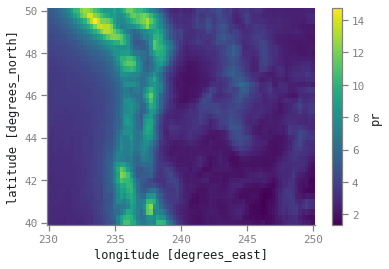

In [ ]:
metrics.wet_day(obs_ds, 'mean').sel(lat=slice(50,40), lon=slice(230,250)).pr.plot()

In [56]:
### If it was wet, how wet was it?

In [ ]:
for metric in ["mean", "median", "std", "percentile95"]:
    plot_values_and_difference(
        metrics.wet_day_amount(obs_ds.pr, method=metric),
        metrics.wet_day_amount(ds["pr"].sel(training_period), method=metric),
        cbar_kwargs={"label": f"{metric} wet day amount"},
        diff_limit=10,
    )

Calculate boolean masks of wet and dry days (they are inverses of eachother)
based upon a threshold. We'll then use these to perform a variety of statistics.


In [ ]:
wet_days_obs = metrics.is_wet_day(obs_ds, threshold=0.05).compute()
dry_days_obs = ~wet_days_obs
wet_days_downscaled = metrics.is_wet_day(
    ds.sel(training_period), threshold=0.05
).compute()
dry_days_downscaled = ~wet_days_downscaled

### Length and variability of wet spells


In [ ]:
for metric in ['mean', 'std', 'percentile90', 'percentile99']"
    plot_values_and_difference(apply_spell_length(wet_days_obs, metric),
                           apply_spell_length(wet_days_downscaled, metric),
                           cbar_kwargs={'label': f'{metric} days'}, diff_limit=10)

### Length and variability of dry spells


In [ ]:
for metric in ['mean', 'std', 'percentile90', 'percentile99']"
    plot_values_and_difference(apply_spell_length(dry_days_obs, metric),
                           apply_spell_length(dry_days_downscaled, metric),
                           cbar_kwargs={'label': f'{metric} days'}, diff_limit=10)

### If today was wet, what are odds tomorrow will be wet?


In [ ]:
plot_values_and_difference(
    metrics.probability_two_consecutive_days(obs_ds, kind_of_days="wet")["pr"],
    metrics.probability_two_consecutive_days(
        ds.sel(time=training_period), kind_of_days="wet"
    )["pr"],
    cbar_kwargs={"label": "probability"},
    diff_limit=0.5,
)

### If today was dry, what are odds tomorrow will be dry?


In [ ]:
plot_values_and_difference(
    metrics.probability_two_consecutive_days(obs_ds, kind_of_days="dry")["pr"],
    metrics.probability_two_consecutive_days(
        ds.sel(time=training_period), kind_of_days="dry"
    )["pr"],
    cbar_kwargs={"label": "probability"},
    diff_limit=0.5,
)

### Low frequency variability - standard deviation of monthly precipitation


In [ ]:
print(run_id)

In [ ]:
plt.plot(range(0, 4), range(0, 4))